In [1]:
import ast
import pandas as pd
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster
from factor_analyzer import FactorAnalyzer
from IPython.display import display, HTML, Markdown
from radon.complexity import cc_rank, cc_visit
from natsort import natsorted, index_natsorted, order_by_index

from plot_utilities import tex_escape
from ast_utilities import decomposed_function

# Introduction

Define some useful constants

In [2]:
MAX_IDLE_SECONDS = 30 # seconds

Define some helper functions. These should eventually be moved to an external file.

In [3]:
SKIP_LIST = {'pokemon', 'APCS', 'TotalDelta', 'FinalProjectDecomposition', 'DSS',
            'URG', 'Project3Score', 'FinalProjectFunctionality', 'FinalProjectTests',
            'Woman', 'NoPrior'}
def correlations(dataframe, x, xl="", yl=""):
    """ Pretty prints the correlation, but not currently in APA style. """
    Ys = set(dataframe.columns)-SKIP_LIST
    for y in Ys:
        if x == y:
            continue
        cor, sig = st.pearsonr(dataframe[x], dataframe[y].fillna(0))
        if sig <= .05:
            print(x, "~", y, "\tCorrelation:", cor)
            sns.regplot(dataframe[x], dataframe[y])
            plt.show()
            #plt.scatter(dataframe[x], dataframe[y])
            #plt.xlabel(xl or x)
            #plt.ylabel(yl or y)
            #plt.title("Relationship between {} and {}".format(x, y))
            #plt.show()
        

In [4]:
from math import sqrt
def proportion_stats(incidences, total, label=None):
    """ Pretty prints a proportion with APA-style statistics. """
    proportion = incidences/total
    rounded_proportion = round(100*proportion*10)/10
    standard_deviation = sqrt(proportion*(1-proportion))/sqrt(total)
    rounded_sd = round(100*standard_deviation)/100
    result = f"n={incidences}, M={rounded_proportion}%, SD={rounded_sd}"
    if label is None:
        return result
    else:
        print(label, result)
print(proportion_stats(50, 100))
proportion_stats(75, 103, 'Test Case')

n=50, M=50.0%, SD=0.05
Test Case n=75, M=72.8%, SD=0.04


# Setup Styling

We are working with a LaTeX document that has 240pt columns and a textwidth of 504pt.

We use the seaborn whitegrid style, but LaTeX fonts so that they fit in with the paper.

In [5]:
from plot_utilities import *
COLUMN_WIDTH = 240/72.27
TEXT_WIDTH = 504/72.27

# Using seaborn's style
plt.style.use('seaborn-whitegrid')

# Setup fonts
nice_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
matplotlib.rcParams.update(nice_fonts)

def save_figure(filename, fig=None):
    """ Helper function to quickly save figures for the paper. """
    if fig is None:
        fig = plt
    fig.savefig('../reports/figures/{}'.format(filename), format='pdf', bbox_inches='tight')

This is just a simple test of the style.

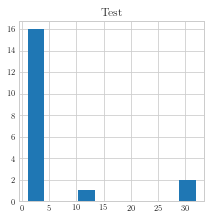

<Figure size 432x288 with 0 Axes>

In [6]:
fig,ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH, COLUMN_WIDTH))
plt.hist([1,2,3,3,3,3,3,2,3,3,3,2,32,3,1,2,12,32,3])
plt.title("Test")
plt.show()
save_figure('example_1.pdf')

In [7]:
# Stop using scientific notation, show two decimal places instead.
pd.set_option('display.float_format', '{:.2f}'.format)

# Loading Data

### Subjects

Import the combined demographic data for the participants

In [8]:
subjects = pd.read_csv("../data/processed/subjects.csv")
subject_ids = ", ".join(repr(str(line)) for line in subjects['SubjectID'])
subjects.set_index('SubjectID', inplace=True)
subjects.index = subjects.index.astype(str)
subjects.head()

,pokemon,OverallScore,QuizScore,Midterm1Score,Midterm2Score,FinalExamScore,FinalExamPart1Score,FinalExamPart2Score,BlockPyEvents,Woman,...,EvaluateFunctionMisconceptions,EvaluateListDictionaryMisconceptions,IdentifyVariablesScope,DetermineNestedDataLength,IdentifyIterationVariableType,LookupCalculation,ModifyDictionaryAlias,TraceFunctionDefinition,TraceIfStatement,LoopTracing
SubjectID,,,,,,,,,,,,,,,,,,,,,
145,Weezing,92.38,94.87,82.65,96.25,97.45,43.45,54.00,10124,NW,...,1.00,1.00,3.00,3.00,3.00,3.00,3.00,0.75,3.00,3.00
104,Giratina,96.63,99.79,95.50,92.58,96.10,42.10,54.00,8637,NW,...,1.00,1.00,3.00,3.00,3.00,3.00,1.50,1.50,3.00,3.00
258,Glameow,14.43,56.50,0.00,0.00,0.00,0.00,0.00,1993,NW,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
247,Lumineon,99.08,100.00,99.00,97.00,99.00,45.00,54.00,11279,NW,...,1.00,1.00,3.00,3.00,3.00,3.00,3.00,3.00,2.00,3.00
147,Squirtle,60.05,81.30,88.46,76.22,74.92,33.34,41.58,10254,NW,...,1.00,0.00,3.00,1.50,2.14,2.00,1.50,1.50,3.00,2.00


In [9]:
display(subjects.Woman.value_counts()) #/ len(subjects))
display(subjects.NoPrior.value_counts()) #/ len(subjects))
display(subjects.URG.value_counts()) #/ len(subjects))
display(subjects.APCS.value_counts()) #/ len(subjects))

NW    83
W     20
Name: Woman, dtype: int64

P     65
NP    38
Name: NoPrior, dtype: int64

RG     97
URG     6
Name: URG, dtype: int64

N       74
APCS    29
Name: APCS, dtype: int64

### Logs

Load in all the event data from the BlockPy snapshots for just the students

In [10]:
logs = pd.read_sql(f"""
SELECT EventID, SubjectID, AssignmentID, EventType, CodeStateID, ClientTimestamp, ServerTimestamp,
       Score, EditType,
       CompileMessageType, CompileMessageData,
       InterventionCategory, InterventionType, InterventionMessage FROM MainTable
WHERE SubjectID IN ({subject_ids})
""", sqlite3.connect('../data/processed/progsnap2_7.db'),
                   parse_dates=['ServerTimestamp', 'ClientTimestamp'],
                  index_col=['EventID'])
logs.ClientTimestamp = logs.ClientTimestamp.fillna(logs.ServerTimestamp)

In [11]:
# Sort them by student and time
logs = logs.sort_values(['SubjectID', 'ServerTimestamp'])

In [12]:
# For simplicity, use the last timestamp as the "end" of the semester
END_OF_TERM = logs.ServerTimestamp.max()
END_OF_TERM

Timestamp('2019-12-12 16:50:48.464871')

In [13]:
# Let's also calculate the starting week
FIRST_WEEK = logs.ServerTimestamp.min().week
FIRST_WEEK

35

In [14]:
logs.sample(5)

,SubjectID,AssignmentID,EventType,CodeStateID,ClientTimestamp,ServerTimestamp,Score,EditType,CompileMessageType,CompileMessageData,InterventionCategory,InterventionType,InterventionMessage
EventID,,,,,,,,,,,,,
2500026,137,275,File.Edit,782510,2019-10-29 18:15:41.445,2019-10-29 17:15:39.080677,,GenericEdit,,,,,
2588697,221,284,File.Edit,822421,2019-11-06 10:58:08.415,2019-11-06 10:58:09.462684,,GenericEdit,,,,,
2422271,237,157,File.Edit,745057,2019-10-24 17:03:27.243,2019-10-24 16:03:27.052621,,GenericEdit,,,,,
2662068,234,281,File.Edit,866687,2019-11-07 18:29:53.729,2019-11-07 18:29:54.785673,,GenericEdit,,,,,
1866898,173,107,Run.Program,473515,2019-10-10 10:55:28.009,2019-10-10 09:55:29.358196,,,,,,,


### Code States

Load in all the code for the code states for just the students

In [15]:
code_states = ", ".join(repr(line) for line in logs['CodeStateID'].unique())

In [16]:
code = pd.read_sql(f"""
SELECT ID, Filename, Contents FROM CodeState
WHERE ID IN ({code_states})
""", sqlite3.connect('../data/processed/progsnap2_7.db'),
                  index_col=['ID'])
code.Contents = code.Contents.str.decode("utf-8")

In [17]:
code.sample(5)

,Filename,Contents
ID,,
520012,answer.py,from cisc108 import assert_equal\ndef make_lis...
598950,answer.py,from cisc108 import assert_equal\n\ndef high_s...
369623,answer.py,from cisc108 import assert_equal\ndef rate_ani...
864376,answer.py,from cisc108 import assert_equal\n\ndef watch_...
152333,answer.py,from cisc108 import assert_equal\ndef make_pol...


### Assignments

Load in all the assignments and their groups

In [18]:
assignments = pd.read_sql(f"""
SELECT LinkAssignment.AssignmentId as AssignmentID,
       LinkAssignment.`X-Name` as AssignmentName,
       LinkAssignmentGroup.`X-Name` as GroupName
FROM LinkAssignment, LinkAssignmentGroup
WHERE LinkAssignment.`X-AssignmentGroup.Ids` = LinkAssignmentGroup.AssignmentGroupId
""", sqlite3.connect('../data/processed/progsnap2_7.db'),
                         index_col=['AssignmentID'])
# Fill in missing data
assignments.loc['273'] = ['Project 4- Crypto Corgi Company']*2
assignments.loc['280'] = ['??? - Monster Mash']*2
assignments.loc['254'] = ['Project 3- Magical Banking']*2
# Load in the due dates from the locks file
lock_dates = pd.read_csv('../data/processed/locks.csv')
assignments = assignments.reset_index().merge(lock_dates, left_on='GroupName', right_on='GroupName').set_index('AssignmentID')
# Drop assignments that lack a due date
assignments = assignments.dropna()
# Kill the stupid timezone
assignments.DueDate = pd.to_datetime(assignments.DueDate, utc=True).dt.tz_convert('America/New_York').dt.tz_localize(None)
# Sort by the due date
sorted_index = index_natsorted(zip(assignments.DueDate.fillna(0), assignments.GroupName, assignments.AssignmentName))
assignments = assignments.reindex(index=order_by_index(assignments.index, sorted_index))

We're going to filter our logs to remove any assignments that don't have a due date.

In [19]:
print("Before filtering unimportant assignments", len(logs))
logs = logs[logs.AssignmentID.isin(assignments.index)]
print("After filtering unimportant assignments", len(logs))

Before filtering unimportant assignments 1447817
After filtering unimportant assignments 1406094


# New Features

In this section, we're going to add a bunch of new features to the Logs and Subjects spreadsheets.
These include things like time spent, earliness (relative to the assignment due date and the semester end date).

### Earliness (Logs)

Add in the amount of time left in the semester, and until the assignment is due.
Both of these are available as deltas or hours.

In [20]:
# Add in the due dates
logs_with_due = logs.merge(assignments, left_on='AssignmentID', right_index=True)
# Calculate difference between event and the due date
# Place all the following columns before the situational ProgSnap ones
COL_POS = logs.columns.get_loc("EditType")
logs.insert(COL_POS+1, 'DueDelta', logs_with_due.DueDate.subtract(logs_with_due.ClientTimestamp).clip(pd.Timedelta(0)))
logs.insert(COL_POS+2, 'DueHours', logs['DueDelta'].dt.total_seconds()/60/60)
logs.insert(COL_POS+3, 'DueSeconds', logs['DueDelta'].dt.total_seconds())

In [21]:
# Calculate difference between event and the due date
logs.insert(COL_POS+4, 'SemesterDelta', (END_OF_TERM - logs.ClientTimestamp))
logs.insert(COL_POS+5, 'SemesterHours', logs['SemesterDelta'].dt.total_seconds()/60/60)

### Event Duration (Logs)

Add in the time spent before the next log entry for this student

In [22]:
# Group all events by subject
logs_grouped_by_subject = logs.sort_values(['SubjectID', 'ServerTimestamp']).groupby(['SubjectID'])
# Calculate difference between adjacent events, bottoming at zero
logs_duration = logs_grouped_by_subject.ServerTimestamp.diff().fillna(pd.Timedelta(seconds=0))
# cap durations to 30 seconds
logs_duration = logs_duration.clip(pd.Timedelta(seconds=0), pd.Timedelta(seconds=MAX_IDLE_SECONDS))
# Insert into table
logs.insert(COL_POS+6, 'DurationDelta', logs_duration)
logs.insert(COL_POS+7, 'DurationSeconds', logs_duration.dt.total_seconds())

In [23]:
logs.sample(5)

,SubjectID,AssignmentID,EventType,CodeStateID,ClientTimestamp,ServerTimestamp,Score,EditType,DueDelta,DueHours,DueSeconds,SemesterDelta,SemesterHours,DurationDelta,DurationSeconds,CompileMessageType,CompileMessageData,InterventionCategory,InterventionType,InterventionMessage
EventID,,,,,,,,,,,,,,,,,,,,
1685204,166,258,File.Edit,399644,2019-10-03 12:54:31.021,2019-10-03 11:40:19.152352,,GenericEdit,1 days 11:05:27.979000,35.09,126327.98,70 days 03:56:17.443871,1683.94,00:00:08.411610,8.41,,,,,
2639749,98,285,File.Edit,853772,2019-11-07 14:36:42.280,2019-11-07 14:36:43.344191,,GenericEdit,1 days 09:23:16.720000,33.39,120196.72,35 days 02:14:06.184871,842.24,00:00:04.043667,4.04,,,,,
2268572,106,157,Intervention,665278,2019-10-21 11:27:35.120,2019-10-21 10:27:35.997990,1,,9 days 12:32:23.880000,228.54,822743.88,52 days 05:23:13.344871,1253.39,00:00:00.001483,0.00,,,Feedback,Complete|Complete,<p>Great work!</p>\n
1819038,101,267,File.Edit,454355,2019-10-09 10:55:35.656,2019-10-09 09:55:36.735711,,GenericEdit,10 days 13:03:24.344000,253.06,911004.34,64 days 05:55:12.808871,1541.92,00:00:30,30.00,,,,,
1411329,237,86,File.Edit,158387,2019-09-25 16:07:44.410,2019-09-25 15:07:44.307377,,GenericEdit,19 days 07:51:15.590000,463.85,1669875.59,78 days 00:43:04.054871,1872.72,00:00:01.084541,1.08,,,,,


### Total Time Spent (Subjects)

Find the total duration of time spent by this student on programming

In [24]:
#total_time_spent.index = total_time_spent.index.astype(int)
subjects['TotalDelta'] = logs.groupby('SubjectID').DurationDelta.sum().rename('TotalDelta')
subjects['TotalHours'] = subjects.TotalDelta.dt.total_seconds()/60/60

### Average Earliness (Subjects)

Calculate the average earliness of all the events grouped by subject.

First we calculate `subjects.EarlySeconds`: The average of all the events in seconds, relative to their assignments' due dates. The calculation here is a little tricky: we are taking the duration of the event into account too.

In [25]:
start = logs.DueSeconds
duration = logs.DurationSeconds
# The mean of a range times the length of the range, add them all up, divide by the cumulative range lengths
range_middles = start*duration+duration.pow(2)/2
range_middles = range_middles.rename("RangeMiddles")
grouped_range_middles = logs.join(range_middles).groupby(['SubjectID']).RangeMiddles
# Calculate the average time that they were working before the due date
average_seconds_left = grouped_range_middles.sum() / logs.groupby(['SubjectID']).DurationSeconds.sum()
subjects['EarlySeconds'] = average_seconds_left

Also calculating the `subjects.EarlySubmissions`, which will be the average number of seconds until the assignment due date, but just for the submissions.

In [26]:
subjects['EarlySubmissions'] = logs[logs.EventType=='Intervention'].groupby('SubjectID').DueSeconds.mean()

### Project Scores (subjects)

The Final project was assessed with a rubric that had a large number of levels. We reduce those levels done to just three (`Bad`, `Good`, `Great`). Those terms were intentionally chosen so that they would be short and alphabetical (and they approximate the sentiments). We'll probably remap them for the paper itself.

`subjects.FinalProjectDecompositionReduced`: The quality of their code's functional decomposition (how much they separated work into helper functions when appropriate).

`subjects.FinalProjectTestsReduced`: The quality of their test coverage and the tests themselves.

`subjects.FinalProjectFunctionalityReduced`: How much of their game's required features they managed to complete. Each game had distinctive functionality, and students could choose from 12 games separated into 3 groups.

In [27]:
# Reduce the levels of the final project assessments
TestLevels = {'Great Tests': 'Great',
              'Decent Tests': 'Good',
              'Good Tests': 'Good',
              'Does not run': 'Bad',
              'Inadequate Tests': 'Bad',
              'Invalid/No Tests': 'Bad'}
DecompositionLevels = {
    'Excellent': 'Great',
    'Adequate': 'Good',
    'Does not run': 'Bad',
    'Inadequate': 'Bad',
    'No decomposition': 'Bad'
}
FunctionalityLevels = {
    'All features complete': 'Great',
    'Most features complete': 'Good',
    'At least half complete': 'Good',
    'Some features complete': 'Bad',
    'Does not run': 'Bad',
    'One feature complete': 'Bad',
    'No features complete': 'Bad'
}
subjects['FinalProjectDecompositionReduced'] = subjects.FinalProjectDecomposition.map(DecompositionLevels)
subjects['FinalProjectTestsReduced'] = subjects.FinalProjectTests.map(TestLevels)
subjects['FinalProjectFunctionalityReduced'] = subjects.FinalProjectFunctionality.map(FunctionalityLevels)
subjects.FinalProjectFunctionalityReduced.value_counts()

Great    48
Good     28
Bad      27
Name: FinalProjectFunctionalityReduced, dtype: int64

### Submissions Only

We are often only interested in the submissions, not all the logs. Take that subset by finding the "Interventions" (which are triggered whenever the student runs their code, and also comes equipped with the feedback they are given).

In [28]:
submissions = logs[logs.EventType=='Intervention']
len(submissions)

122511

### Sampling Subjects

Here's a clear example of all the fields available in the Subjects table now.

In [29]:
subjects.sample(5).T

SubjectID,204,241,228,258,253
pokemon,Arbok,Wynaut,Houndour,Glameow,Pikachu
OverallScore,78.61,79.51,76.96,14.43,81.76
QuizScore,83.64,94.95,98.93,56.50,96.01
Midterm1Score,73.03,66.70,82.33,0.00,84.72
Midterm2Score,83.28,80.83,71.33,0.00,86.25
FinalExamScore,82.10,79.68,65.65,0.00,88.99
FinalExamPart1Score,35.12,37.02,37.03,0.00,34.99
FinalExamPart2Score,46.98,42.66,28.62,0.00,54.00
BlockPyEvents,14685,10143,23612,1993,17832
Woman,NW,NW,W,NW,NW


# Basic Outcomes Analysis

Let's look at the distributions of the major assessments.

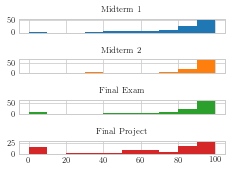

In [30]:
titles = ['Midterm 1', 'Midterm 2', 'Final Exam', 'Final Project']
axes = subjects.plot(kind='hist',
                     y=['Midterm1Score', 'Midterm2Score', 'FinalExamScore', 'FinalProjectScore'],
             sharex=True, layout=(4, 1), figsize=(COLUMN_WIDTH, .75*COLUMN_WIDTH),
              subplots=True, title=titles, legend=False,
             bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
for ax, title in zip(axes, titles):
    #ax[0].title.set_visible(False)
    ax[0].set_ylabel("")
    ax[0].set_title(title, fontsize='small')
    #ax[0].titlesize = 10
#plt.plot(subjects[['Midterm1Score', 'Midterm2Score', 'FinalExamScore', 'FinalProjectScore']], alpha=.25)
#sns.pairplot(subjects[['Midterm1Score', 'Midterm2Score', 'FinalExamScore', 'FinalProjectScore']],
#             height=TEXT_WIDTH/4, corner=True)
plt.tight_layout()
save_figure('grade_distributions.pdf')
plt.show()

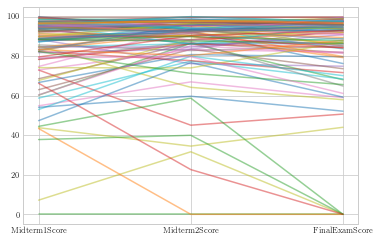

In [31]:
# Parallel coordinate plot to see how they progress over the course of the semester.

plt.plot(subjects[['Midterm1Score', 'Midterm2Score', 'FinalExamScore']].T, alpha=.5)
plt.show()

# Parameter Overwrite

Determine which students have overwritten parameters at any point during the semester. Parameter overwritting is when students immediately assign a literal value to a parameter (clobbering its value). The instructor observed that a number of students (especially when first learning about parameters and arguments) would do this mistake.

In [32]:
from ast_utilities import function_with_reinitialization
#parameter_overwrites = code.Contents.apply(function_with_reinitialization)
# Give the column a better name
#parameter_overwrites = parameter_overwrites.rename('ParametersOverwritten')
# Turn them into just frequencies by replacing False (No overwrites) and None (unparseable)
#parameter_overwrites = 

subs_with_PO = submissions.merge(code.Contents, left_on='CodeStateID', right_on='ID')
subs_with_PO['ParametersOverwritten'] = subs_with_PO.Contents.apply(function_with_reinitialization)
subs_with_PO['ParametersOverwritten'] = subs_with_PO['ParametersOverwritten'].replace({False: "", None: ""}).map(len)

In [33]:
# Take the subset of logs where a parameter is overwritten and they were submitting
# Yeesh who overwrote 21 parameters?
only_subs_with_PO = subs_with_PO[subs_with_PO.ParametersOverwritten > 0]
only_subs_with_PO.ParametersOverwritten.describe()

count   1973.00
mean       5.90
std        3.42
min        1.00
25%        4.00
50%        5.00
75%        7.00
max       21.00
Name: ParametersOverwritten, dtype: float64

Let's see how the rate of this changes over the course of the semester.

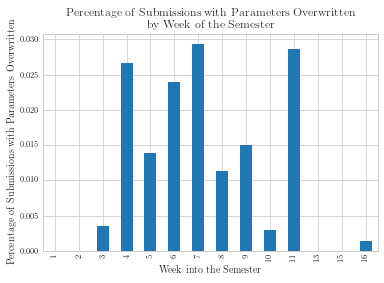

In [34]:
plt.title("Percentage of Submissions with Parameters Overwritten\nby Week of the Semester")
plt.xlabel("Week into the Semester")
plt.ylabel("Percentage of Submissions with Parameters Overwritten")
po_week_count = (END_OF_TERM-only_subs_with_PO.SemesterDelta).dt.week.value_counts()
subs_week_count = (END_OF_TERM-submissions.SemesterDelta).dt.week.value_counts()
weekly_parameter_overwrite = (po_week_count/subs_week_count)
weekly_parameter_overwrite.index = weekly_parameter_overwrite.index - FIRST_WEEK+1
weekly_parameter_overwrite.plot.bar()
plt.show()

Is the Y-axis clearer if we check the "number of students with a PO submission" instead of percentage of submissions?

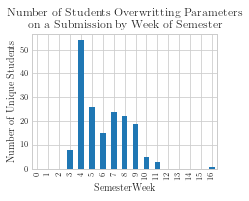

In [35]:
semester_weeks = only_subs_with_PO.assign(SemesterWeek=only_subs_with_PO.ClientTimestamp.dt.week)
weekly_parameter_overwrite = semester_weeks.groupby('SemesterWeek').SubjectID.nunique()
weekly_parameter_overwrite.index = (weekly_parameter_overwrite.index - FIRST_WEEK+1)
weekly_parameter_overwrite = weekly_parameter_overwrite.reindex(range(0, 17), fill_value=0)
plt.figure(figsize=(COLUMN_WIDTH, .75*COLUMN_WIDTH))
plt.ylabel("Number of Unique Students")
plt.xlabel("Week into the Semester")
plt.title("Number of Students Overwritting Parameters\non a Submission by Week of Semester")
weekly_parameter_overwrite.plot.bar()
plt.show()

And let's see if there's a relationship with the final exam score.

Looks like there's actually a pretty strong negative correlation. If you frequently overwrite your parameters, you're probably not going to do very well on the final exam.

SpearmanrResult(correlation=-0.4882397430645421, pvalue=1.6801113539503117e-07)

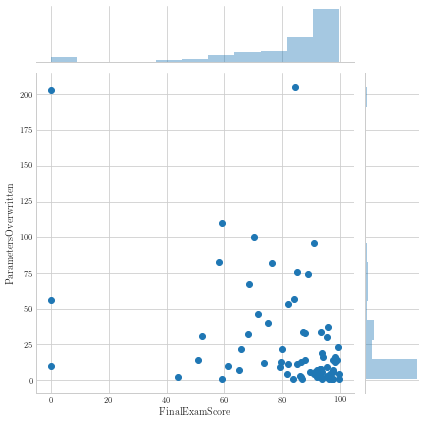

In [36]:
subjects_PO = only_subs_with_PO.groupby('SubjectID').ParametersOverwritten.count()
subjects_with_po = subjects.join(subjects_PO)
subjects_with_po.FinalExamScore.corr(subjects_with_po.ParametersOverwritten)
sns.jointplot(subjects_with_po.FinalExamScore, subjects_with_po.ParametersOverwritten)
st.spearmanr(subjects_with_po.FinalExamScore, subjects_with_po.ParametersOverwritten.fillna(0))

What assignments had the highest number of students overwritting their parameters?

In [37]:
po_log_named = only_subs_with_PO.merge(assignments, left_on='AssignmentID', right_on='AssignmentID')
po_log_named.groupby('GroupName').SubjectID.unique().map(len).sort_values(ascending=False)

GroupName
#20) Programming: Defining Functions          46
#23) Programming: Scope                       22
#22) Programming: Return and Print            16
#39) Programming: Dictionaries                15
#33) Programming: Loop Patterns               14
#29) Programming: Nesting Blocks              14
#31) Programming: List Operations             13
#21) Programming: Unit Tests                  12
F19 - Midterm Exam 1                          12
#32) Programming: For Loops                   11
#25) Programming: Functional Decomposition     7
Project 4- Crypto Corgi Company                7
#36) Programming: Mutability                   6
#37) Programming: Lists vs. Strings            6
#40) Programming: Dictionary Operations        5
#35) Programming: Loop Composition             5
Project 3- Magical Banking                     4
#34) Programming: Loop Patterns 2              4
#30) Programming: Lists                        3
#43) Programming: Nested Data                  3
#39) Progr

The number of times that students overwrote parameters on their first exposure (lesson #20) did not have any relationship with their final exam score.

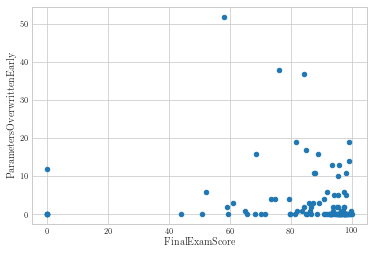

SpearmanrResult(correlation=-0.1374397881813451, pvalue=0.1662305737006435)

In [38]:
# Does 
assignment_20_logs = po_log_named[po_log_named.GroupName == '#20) Programming: Defining Functions']
subs_with_po_assignment_20 = assignment_20_logs.groupby("SubjectID").ParametersOverwritten.count()
subs_with_po_assignment_20 = subs_with_po_assignment_20.rename("ParametersOverwrittenEarly")
subjects_with_po_assig_20 = subjects.join(subs_with_po_assignment_20)
subjects_with_po_assig_20.ParametersOverwrittenEarly.fillna(0, inplace=True)
subjects_with_po_assig_20.plot.scatter('FinalExamScore', 'ParametersOverwrittenEarly')
plt.show()
st.spearmanr(subjects_with_po_assig_20.ParametersOverwrittenEarly, subjects_with_po_assig_20.FinalExamScore)

# Spaced/Massed Practice

How long did students spend working on their assignments, compared to their final exam score?
Small negative correlation, it appears.

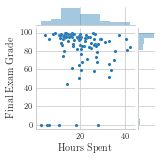

SpearmanrResult(correlation=-0.318495373363273, pvalue=0.0010426848658479273)

In [39]:
h = sns.jointplot(x=subjects.TotalHours, y=subjects.FinalExamScore, kind='scatter', height=TEXT_WIDTH/3,
                 s=10, edgecolor="w", linewidth=.1)
h.set_axis_labels('Hours Spent', 'Final Exam Grade')
#h.set_title_label("Earliness vs. Final Exam Grade in Course")
save_figure('scatter_timespent_finalexam.pdf')
plt.show()

st.spearmanr(subjects.TotalHours, subjects['FinalExamScore'])

However, their procrastination (earliness) did seem to have a strong correlation.

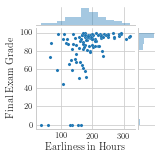

SpearmanrResult(correlation=0.4921022908506945, pvalue=1.2967182074936127e-07)

In [40]:
h = sns.jointplot(x=subjects.EarlySubmissions/60/60, y=subjects.FinalExamScore, kind='scatter', height=TEXT_WIDTH/3,
                 s=10, edgecolor="w", linewidth=.1)
h.set_axis_labels('Earliness in Hours', 'Final Exam Grade')
#h.set_title_label("Earliness vs. Final Exam Grade in Course")
save_figure('scatter_earliness_finalexam.pdf')
plt.show()
st.spearmanr(subjects.EarlySubmissions, subjects.FinalExamScore)

Also unexpected, there was pretty much no correlation at all between their earliness and their time spent.

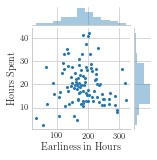

SpearmanrResult(correlation=-0.09104687431357905, pvalue=0.3603757123443171)

In [41]:
h = sns.jointplot(x=subjects.EarlySubmissions/60/60, y=subjects.TotalHours, kind='scatter', height=TEXT_WIDTH/3,
                 s=10, edgecolor="w", linewidth=.1)
h.set_axis_labels('Earliness in Hours', 'Hours Spent')
#h.set_title_label("Earliness vs. Final Exam Grade in Course")
save_figure('scatter_earliness_timespent.pdf')
plt.show()
st.spearmanr(subjects.EarlySubmissions, subjects.TotalHours)

Attempted to fit the earliness and time spent to the final exam. However, the R-squared is not very impressive. Probably not a good linear combination to predict the Final Exam Score.

In [42]:
sm.OLS.from_formula(formula="FinalExamScore ~ EarlySubmissions + TotalHours", data=subjects).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         FinalExamScore   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     15.08
Date:                Tue, 30 Jun 2020   Prob (F-statistic):           1.89e-06
Time:                        11:48:07   Log-Likelihood:                -459.82
No. Observations:                 103   AIC:                             925.6
Df Residuals:                     100   BIC:                             933.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           41.0037      9.083      4.515      0.000      22.984      59.023
EarlySubmissions  5.787e-05   1.06e-05      5.472      0.000    3.69e-05    7.88e-05
TotalHours           0.1769      0.257      0.688      0.493      -0.333       0.687
==============================================================================
Omnibus:                       50.019   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.692
Skew:                          -1.821   Prob(JB):                     9.31e-30
Kurtosis:                       7.230   Cond. No.                     3.00e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Logistic Regression model tried instead. Not very effective either, sadly.

Optimization terminated successfully.
         Current function value: 0.386280
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         FinalExamScore   No. Observations:                  103
Model:                          Logit   Df Residuals:                      102
Method:                           MLE   Df Model:                            0
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:                  0.1377
Time:                        11:48:11   Log-Likelihood:                -39.787
converged:                       True   LL-Null:                       -46.139
Covariance Type:            nonrobust   LLR p-value:                       nan
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
EarlySubmissions  2.898e-06   4.67e-07      6.203      0.000    1.98e-06    3.81e-06
====================================================================================
"""

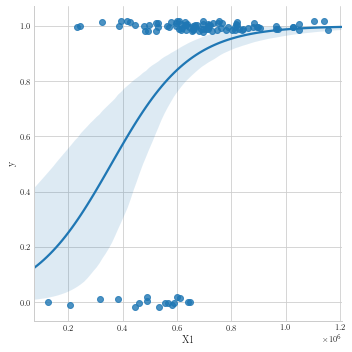

In [43]:
y = (subjects.FinalExamScore >= 70).map(int)
X = subjects.EarlySubmissions
df = pd.DataFrame({'y': y, 'X1': subjects.EarlySubmissions, 'X2': subjects.TotalHours })
g = sns.lmplot(x='X1', y="y", data=df,
               y_jitter=.02, logistic=True, truncate=False)
display(sm.Logit(y, subjects[['EarlySubmissions']]).fit().summary())

Analyze each of the main demographic subgroups for their time spent, earliness, and final exam score.

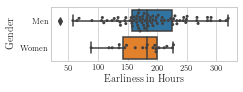

KruskalResult(statistic=0.7090593141797967, pvalue=0.39975627375882317)


Woman
Men     187.64
Women   173.58
Name: EarlySubmissions, dtype: float64

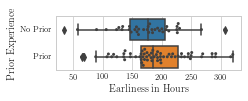

KruskalResult(statistic=1.9061351603861567, pvalue=0.16739320400222463)


NoPrior
No Prior   173.81
Prior      191.40
Name: EarlySubmissions, dtype: float64

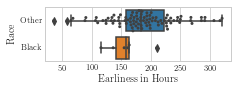

KruskalResult(statistic=2.9508326724821927, pvalue=0.08583332287267194)


URG
Black   156.54
Other   186.67
Name: EarlySubmissions, dtype: float64

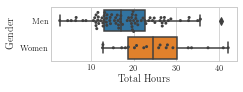

KruskalResult(statistic=9.774675625579277, pvalue=0.0017693193302769068)


Woman
Men     18.34
Women   25.26
Name: TotalHours, dtype: float64

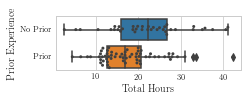

KruskalResult(statistic=7.288617253192172, pvalue=0.006939286561764235)


NoPrior
No Prior   22.46
Prior      18.06
Name: TotalHours, dtype: float64

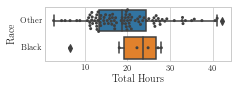

KruskalResult(statistic=0.713719270420313, pvalue=0.3982118624359787)


URG
Black   21.11
Other   19.59
Name: TotalHours, dtype: float64

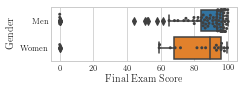

KruskalResult(statistic=1.8700427972518987, pvalue=0.17147017796741165)


Woman
Men     84.56
Women   76.56
Name: FinalExamScore, dtype: float64

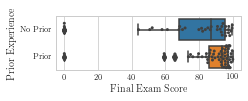

KruskalResult(statistic=5.513513816980335, pvalue=0.018870099556461694)


NoPrior
No Prior   75.03
Prior      87.67
Name: FinalExamScore, dtype: float64

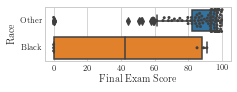

KruskalResult(statistic=6.38966160908822, pvalue=0.01147869085774442)


URG
Black   44.18
Other   85.41
Name: FinalExamScore, dtype: float64

In [44]:
metrics = [(subjects.EarlySubmissions/60/60, 'Earliness in Hours', 'earliness'),
           (subjects.TotalHours, 'Total Hours', 'hours'),
           (subjects.FinalExamScore, 'Final Exam Score', 'finalexam')]
categories = [(subjects.Woman.map({'W': 'Women', 'NW': 'Men'}), 'Gender', 'gender'),
              (subjects.NoPrior.map({"NP": "No Prior", "P": "Prior"}), 'Prior Experience', 'prior'),
             (subjects.URG.map({"RG": "Other", "URG": "Black"}), "Race", "urg")]

for m, mt, mf in metrics:
    for c, ct, cf in categories:
        plt.figure(figsize=(COLUMN_WIDTH, 1))
        h = sns.boxplot(x=m, y=c)
        h = sns.swarmplot(x=m, y=c, color=".25", size=3)
        h.set_xlabel(mt)
        h.set_ylabel(ct)
        save_figure(f'boxplot_{mf}_{cf}.pdf')
        plt.show()
        k = st.kruskal(*[g.values for n, g in m.groupby(c)])
        print(k)
        display(m.groupby(c).mean())


# Analyzing Assignments

Find the assignments that took up the most time across all students.

In [45]:
event_counts = logs.groupby('AssignmentID').DurationDelta.sum().rename('TimeSpent')
assignments_with_time_spent = assignments.join(event_counts).sort_values('TimeSpent', ascending=False).dropna()
# Hardest Problems
assignments_with_time_spent.head(10)

,AssignmentName,GroupName,DueDate,TimeSpent
AssignmentID,,,,
273,Project 4- Crypto Corgi Company,Project 4- Crypto Corgi Company,2019-10-24 23:59:00,6 days 19:20:17.497541
254,Project 3- Magical Banking,Project 3- Magical Banking,2019-10-10 23:59:00,5 days 18:00:42.883914
280,??? - Monster Mash,??? - Monster Mash,2019-11-05 23:59:00,2 days 12:13:52.328489
285,M2- P2- Q5,F19 - Midterm Exam 2,2019-11-08 23:59:59,1 days 20:35:02.664273
292,FE Part 2) Question 4,F19 - Final Exam,2019-12-12 23:59:59,1 days 18:06:17.531176
271,#35.4) High Score,#35) Programming: Loop Composition,2019-10-19 23:59:00,1 days 16:24:22.670022
270,#35.3) Heart of the Cards,#35) Programming: Loop Composition,2019-10-19 23:59:00,1 days 12:49:44.210657
91,#25.1) Timely Extraction,#25) Programming: Functional Decomposition,2019-09-27 23:59:59,1 days 07:32:53.812604
267,#34.1) A Fruitless Search,#34) Programming: Loop Patterns 2,2019-10-19 23:59:00,1 days 06:40:38.117261


### Grid of Assignment/Subjects

Construct a grid of the seconds spent on each assignment. Columns are assignments, rows are for each student.

In [46]:
duration_grid = logs.groupby(['AssignmentID', 'SubjectID']).DurationDelta.sum().dt.total_seconds().unstack('AssignmentID')
# Reorder the columns by assignemnt's natural ordering (duedate and name)
duration_grid.columns = assignments.index[assignments.index.isin(duration_grid)]

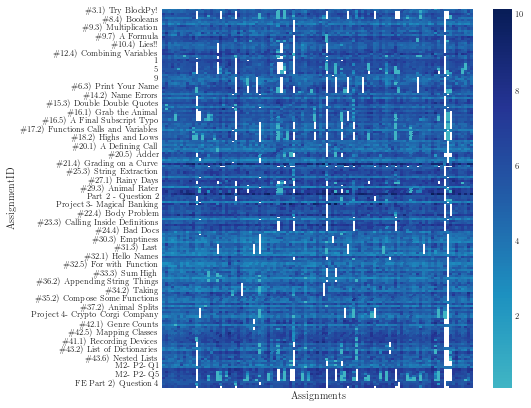

In [47]:
plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH))
# Have to escape the names for LaTeX
duration_grid_with_assignment_names = duration_grid.rename(columns=assignments.AssignmentName.apply(tex_escape))
# Apply a log1p transformation to unskew things
sns.heatmap(duration_grid_with_assignment_names.applymap(np.log1p).T, center=0, cmap="YlGnBu")
plt.xticks([])
plt.xlabel("Subjects")
plt.xlabel("Assignments")
plt.show()

### Maze 10 Activity

Determine how much time students spent on Maze 10, which was much more difficult but largely optional presented as optional. 

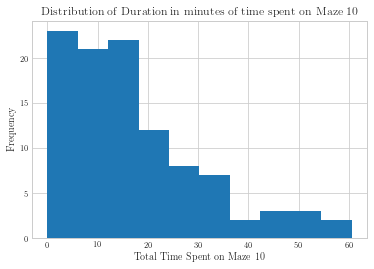

In [48]:
# Get the logs for Maze 10
subjects_maze10_time = logs[logs.AssignmentID=='12'].groupby('SubjectID')
minutes_on_maze10 = subjects_maze10_time.DurationSeconds.sum().div(60).rename('Maze10Time')

minutes_on_maze10.plot.hist()
plt.title("Distribution of Duration in minutes of time spent on Maze 10")
plt.xlabel("Total Time Spent on Maze 10")
plt.show()

No correlation between students who time spent on Maze 10 and students' procrastination.

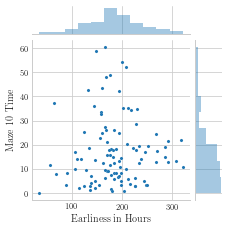

SpearmanrResult(correlation=0.08589597153275053, pvalue=0.38829923642685793)

In [49]:
# Probably not important, but time on Maze 10 correlates to project score a little
subjects_with_maze = subjects.join(minutes_on_maze10)
h = sns.jointplot(x=subjects_with_maze.EarlySubmissions/60/60, y=subjects_with_maze.Maze10Time, kind='scatter', height=COLUMN_WIDTH,
                 s=10, edgecolor="w", linewidth=.1)
h.set_axis_labels('Earliness in Hours', 'Maze 10 Time')
#h.set_title_label("Earliness vs. Final Exam Grade in Course")
save_figure('scatter_earliness_maze10.pdf')
plt.show()
st.spearmanr(subjects_with_maze.EarlySubmissions, subjects_with_maze.Maze10Time)

Nor does their time spent in the course as a whole correlate to their time spent in the Maze.

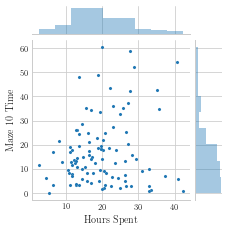

SpearmanrResult(correlation=0.06891666300575496, pvalue=0.4891164371205605)

In [50]:
# Probably not important, but time on Maze 10 correlates to project score a little
h = sns.jointplot(x=subjects_with_maze.TotalHours, y=subjects_with_maze.Maze10Time, kind='scatter', height=COLUMN_WIDTH,
                 s=10, edgecolor="w", linewidth=.1)
h.set_axis_labels('Hours Spent', 'Maze 10 Time')
#h.set_title_label("Earliness vs. Final Exam Grade in Course")
save_figure('scatter_timespent_maze10.pdf')
plt.show()
st.spearmanr(subjects_with_maze.TotalHours, subjects_with_maze.Maze10Time)

### Time Spent Per Week

In [51]:
#logs.DurationDelta
time_per_subject_week = logs.assign(SemesterWeek=logs.ServerTimestamp.dt.week).groupby(["SemesterWeek", "SubjectID"])
time_per_subject_week = time_per_subject_week.DurationSeconds.sum()/3600
time_per_subject_week = time_per_subject_week.unstack().fillna(0)
time_per_subject_week.index = (time_per_subject_week.index - FIRST_WEEK+1)
time_per_subject_week = time_per_subject_week.reindex(range(1, 17), fill_value=0)

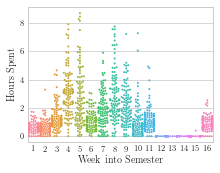

In [52]:
#time_per_subject_week.plot.box()
#plt.show()
plt.figure(figsize=(COLUMN_WIDTH, .75*COLUMN_WIDTH))
#sns.boxplot(data=time_per_subject_week.T)
sns.swarmplot(data=time_per_subject_week.T, alpha=1, size=2)
#time_per_subject_week.T.plot.box(legend=False,)
plt.ylabel("Hours Spent")
plt.xlabel("Week into Semester")
save_figure('time_per_subject_week.pdf')
plt.show()

In [53]:
print(time_per_subject_week.sum().median())
print(time_per_subject_week.sum().mean())
print(time_per_subject_week.sum().max())

19.238446475
19.68029458862729
42.19459596916666


# Final Project

Analyze various factors related to the final project.

In [54]:
# Contingency table of Decomposition and Testing for final project
contingency_table = pd.crosstab(
    subjects.FinalProjectDecompositionReduced,
    subjects.FinalProjectTestsReduced,
    margins = True
)
contingency_table

FinalProjectTestsReduced,Bad,Good,Great,All
FinalProjectDecompositionReduced,,,,
Bad,23,6,3,32
Good,12,21,7,40
Great,7,12,12,31
All,42,39,22,103


# Final Exam

### Clustering Exam Scores

Run KMeans on the exams, to find their clusters.

In [55]:
import random

<Figure size 239.103x239.103 with 0 Axes>

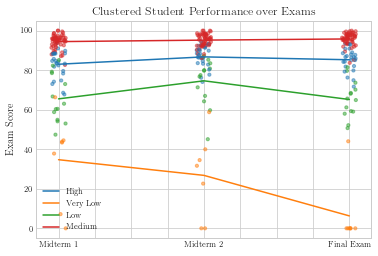

In [56]:
times = ['Midterm1Score', 'Midterm2Score', 'FinalExamScore']
CLUSTERS = 4
LABELS = ['High', "Very Low", "Low", 'Medium'][:CLUSTERS]
df = subjects[times].fillna(0)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
kmeans = KMeans(n_clusters=CLUSTERS).fit(df)
centroids = np.transpose(kmeans.cluster_centers_)
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH))
f = pd.DataFrame(centroids, columns=LABELS, index=["Midterm 1", "Midterm 2", "Final Exam"]).plot.line()
#plt.plot(df.T, 'o', alpha=.1)#, c=kmeans.labels_)
for i, time in enumerate(times):
    plt.scatter([i+(.5-random.random())/10 for x in range(len(df))], 
                df[time], c=[color_cycle[l] for l in kmeans.labels_], s=10, alpha=.5)
plt.title("Clustered Student Performance over Exams")
plt.ylabel("Exam Score")
plt.show()
#plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
#plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
#plt.show()

### Clustering Exam Questions

Attempt to run a Hierarchical Clustering algorithm on a few selected exam questions. Then we'll find the average within each cluster and see how well they fit.

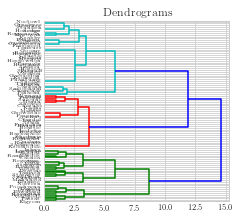

In [57]:
#FinalDetermineAppropriateDataFlow
#FinalIdentifyPrintAsOneWay
#FinalEvaluateListDictionaryMisconception
#FinalModifyDictionaryAlias
#FinalTraceFunctionDefinition
#FinalTraceIfStatement
#FinalTraceLoop
exam_columns = ['DetermineAppropriateDataFlow',
                'IdentifyPrintAsOneWay',
                #'FinalEvaluateListDictionaryMisconception', 'FinalModifyDictionaryAlias',
                'TraceFunctionDefinition', 
                #'FinalTraceIfStatement',
                'LoopTracing'
               ]
exam_questions = subjects[exam_columns].dropna()
exam_questions = exam_questions.apply(lambda r: r.rank(method='dense'))
#exam_questions = (exam_questions == exam_questions.max()).applymap(int)
#exam_questions = pd.DataFrame(normalize(exam_questions), columns=exam_columns)

plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH))  
plt.title("Dendrograms")  
links = shc.linkage(exam_questions, method='ward')
dend = shc.dendrogram(links, orientation='right', labels=subjects.pokemon)

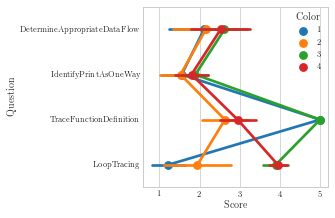

In [58]:
fe_groups = fcluster(links, t=4, criterion='maxclust')
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH))
unstacked = exam_questions.copy()
unstacked['Color'] = fe_groups
unstacked = unstacked.melt(id_vars='Color', var_name='Question', value_name='Score')
sns.pointplot(x='Score', y='Question', hue='Color', data=unstacked, ci='sd')
plt.show()

Did any of this even make sense? I'm not sure what to do with this. I guess I can separate out these students who did poorly/well on the tracing questions? There seem to be four groups there - combos of P/F on the two questions.

In [59]:
exam_questions.assign(Group=fe_groups).groupby('Group').mean()

,DetermineAppropriateDataFlow,IdentifyPrintAsOneWay,TraceFunctionDefinition,LoopTracing
Group,,,,
1,2.11,1.56,5.00,1.22
2,2.16,1.53,2.63,1.95
3,2.62,1.90,5.00,3.90
4,2.52,1.80,2.95,3.95


I mean what I would maybe given this data is see if I can build "profiles" of students based off of how they scored on combos different questions, and then those clusters could be seen as different "types" of students. So each dim is a question score and each point is a student

I think one thing I would do if I had this high dimensional data where each dim is a students response to a question would be to PCA it into 2 dimensions and see if any clusters show up

,0,1,2,3,4,5,6,7
DictionaryVsListIndexing,-0.20,0.40,0.12,-0.36,-0.07,-0.05,-0.15,-0.12
EvaluateConditionals,-0.28,0.11,0.27,0.21,-0.19,0.41,0.11,0.27
LookupCalculation,-0.08,0.31,-0.38,0.49,0.03,-0.11,-0.00,-0.07
IdentifyLiteralType,-0.12,0.04,0.51,0.16,0.32,-0.30,-0.08,0.08
DetermineNestedDataLength,-0.38,-0.07,-0.02,-0.19,-0.23,0.08,-0.25,0.10
WriteFunctionCall,-0.20,-0.35,-0.26,-0.13,0.16,-0.26,0.12,-0.36
IdentifyVariablesScope,-0.19,-0.27,-0.32,-0.15,0.25,0.27,0.15,0.07
TraceFunctionDefinition,-0.15,0.23,-0.08,0.11,0.52,0.01,0.48,0.34
DetermineAppropriateDataFlow,-0.32,-0.20,-0.26,0.11,-0.13,-0.20,-0.04,0.34
IdentifyPrintAsOneWay,-0.30,-0.12,0.13,-0.06,0.17,0.05,0.22,-0.33


17 => 8
[0.2038319  0.11615762 0.08514188 0.07727499 0.06537487 0.06109344
 0.05682862 0.05157612]
0.7172794453874421


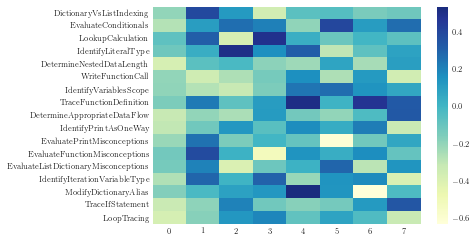

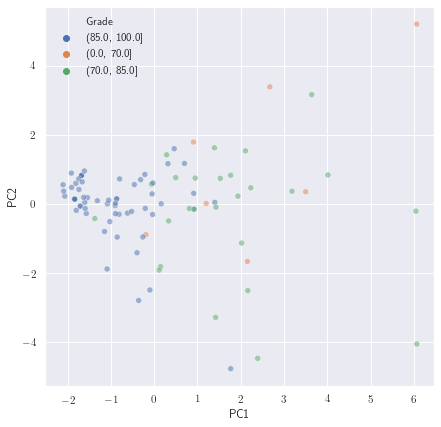

<Figure size 502.117x502.117 with 0 Axes>

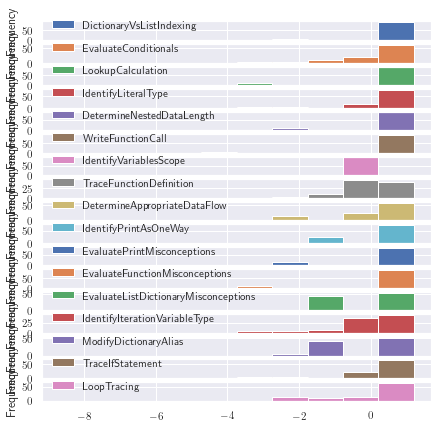

In [60]:
exam_columns = [## Expression-focused
                'DictionaryVsListIndexing', 
                'EvaluateConditionals', 
                'LookupCalculation',
                'IdentifyLiteralType',
                 'DetermineNestedDataLength',
    
                # Function calls
                'WriteFunctionCall', 
                'IdentifyVariablesScope',
                'TraceFunctionDefinition', 
                'DetermineAppropriateDataFlow', 
    
                ## Misconceptions
                'IdentifyPrintAsOneWay',
                'EvaluatePrintMisconceptions',
                'EvaluateFunctionMisconceptions', 
                'EvaluateListDictionaryMisconceptions',
    
                'IdentifyIterationVariableType', 
                 'ModifyDictionaryAlias',
                # Tracing related
                #'DetermineAppropriateDataFlow', 
                #'TraceFunctionDefinition', 
                'TraceIfStatement',
                'LoopTracing'
               ]
exam_questions = subjects[exam_columns].dropna()
x = StandardScaler().fit_transform(exam_questions)
# Alternative methods considered, but ultimately rejected
#x = exam_questions.rank(method='dense')/exam_questions.rank(method='dense').max() # Rank question scores
#x = exam_questions/exam_questions.max() # Normalize by max possible points
#x = StandardScaler().fit_transform(exam_questions/exam_questions.max()) # Normalize and standardize

pca = PCA(.7)#n_components=3)
principalComponents = pca.fit_transform(x)
component_loadings = pd.DataFrame(pca.components_, columns=exam_columns).T
display(component_loadings)
print(len(exam_columns), "=>", len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
sns.heatmap(component_loadings, center=0, cmap="YlGnBu")
plt.show()
N = 1+len(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents, columns = [f'PC{i}' for i in range(1, N)], 
                           index=exam_questions.index)
principalDf['Grade'] = pd.cut(subjects.OverallScore, [0, 70, 85, 100])
#plt.scatter(principalDf.PC1, principalDf.PC2, color=principalDf.color, alpha=.5)
sns.set(rc={'figure.figsize':(TEXT_WIDTH,TEXT_WIDTH)})
sns.scatterplot(x="PC1", y="PC2", hue="Grade", data=principalDf, alpha=.5)
plt.show()
plt.figure()
(pd.DataFrame(x, columns=exam_columns)).plot.hist(subplots=True)
plt.show()

# Functional Decomposition Analysis

In [61]:
from ast_utilities import count_function_definitions

In [62]:
def analyze_assignment(assignment_id, name):
    assignment_logs = logs[logs.AssignmentID == assignment_id]
    assignment_submissions = assignment_logs[assignment_logs.EventType=='Intervention']
    assignment_logs_by_subject = assignment_logs.groupby("SubjectID")
    assignment_submissions_by_subject = assignment_submissions.groupby("SubjectID")
    # Time on task
    total_time = assignment_logs_by_subject.DurationSeconds.sum().rename(name+"TotalTime")
    # Average Earliness of Events and Submissions
    early_events = assignment_logs_by_subject.DueHours.mean().rename(name+"EarlyEvents")
    early_submissions = assignment_submissions_by_subject.DueHours.mean().rename(name+"EarlySubmissions")
    # Count of Events and Submissions
    count_events = assignment_logs_by_subject.Score.count().rename(name+"CountEvents")
    count_submissions = assignment_submissions_by_subject.Score.count().rename(name+"CountSubmissions")
    # Final Score
    final_score = assignment_logs_by_subject.Score.max().rename(name+"FinalScore").replace({'': 0}).astype(float)
    # Count functions
    code_submissions = assignment_submissions.merge(code, left_on='CodeStateID', right_index=True)
    code_submissions['CountFunctions'] = code_submissions.Contents.map(count_function_definitions)
    count_functions = code_submissions.groupby("SubjectID").CountFunctions.max().rename(name+"CountFunctions")
    # Check Actual Decomposition
    code_submissions['HadDecomposition'] = code_submissions.Contents.map(decomposed_function)
    had_decomps = code_submissions.groupby("SubjectID").HadDecomposition.any().map(int).rename(name+'Decomposed')
    # Build up combined table
    decomposition_subjects = pd.concat([#total_time, early_events, early_submissions,
                                        #count_events, count_submissions, 
                                        #count_functions
        final_score,
        (final_score/count_submissions).rename(name+'ScoredSubs'), had_decomps
    ], axis=1)
    return decomposition_subjects
    
decomposition_problems = {
    #'FirstLesson': '91', # 25.1) Timely Exchange (guided)
    'LaterAssignment': '270', # 35.3) Heart of the cards (guided)
    'OpenEndedAssignment': '271', # 35.4) High Score (unguided)
    #'MajorProject': '273', # Project 4 (unguided)
    'Midterm2': '285', 
    'FinalExam': '292'
}
# CountSubmissions, Score, CountFunctions
decomp_table = pd.concat([analyze_assignment(aid, name) for name, aid in decomposition_problems.items()], axis=1).fillna(0)
decomp_table.head()

,LaterAssignmentFinalScore,LaterAssignmentScoredSubs,LaterAssignmentDecomposed,OpenEndedAssignmentFinalScore,OpenEndedAssignmentScoredSubs,OpenEndedAssignmentDecomposed,Midterm2FinalScore,Midterm2ScoredSubs,Midterm2Decomposed,FinalExamFinalScore,FinalExamScoredSubs,FinalExamDecomposed
101,1.00,0.04,1.00,1.00,0.02,0.00,1.00,0.08,0.00,1.00,0.08,0.00
102,1.00,0.06,1.00,1.00,0.02,1.00,0.88,0.10,0.00,0.54,0.02,0.00
104,1.00,0.09,1.00,1.00,0.09,0.00,0.93,0.05,0.00,1.00,0.11,0.00
105,1.00,0.04,1.00,1.00,0.09,0.00,1.00,0.14,0.00,1.00,0.07,0.00
106,1.00,0.11,1.00,1.00,0.04,0.00,1.00,0.06,0.00,1.00,0.02,0.00


Check to see decomposition behavior on different assignments. Interestingly, it looks like people who used decomposition were actually more successful. How can we statistically quantify this?

In [63]:
# Find the cross tab for final exam's use of decomposition vs. success
for name in decomposition_problems:
    #minimum_functions = 4 if name == 'MajorProject' else 1
    exam_did_decompose = decomp_table[name+'Decomposed'].apply(lambda c: 'yes' if c > 0 else 'no').rename("Decomposed?")
    exam_did_solve = decomp_table[name+'FinalScore'].apply(lambda c: 'perfect' if c >= 1 else 'medium' if c > 0 else 'fail').rename("Score")
    df = pd.crosstab(exam_did_solve, exam_did_decompose).T
    df = df.style.set_caption(name)
    display(df)

Score,fail,medium,perfect
Decomposed?,,,
no,19,0,1
yes,2,1,78


Score,fail,perfect
Decomposed?,,
no,27,29
yes,8,37


Score,fail,medium,perfect
Decomposed?,,,
no,7,36,40
yes,0,5,13


Score,fail,medium,perfect
Decomposed?,,,
no,6,38,42
yes,0,8,7


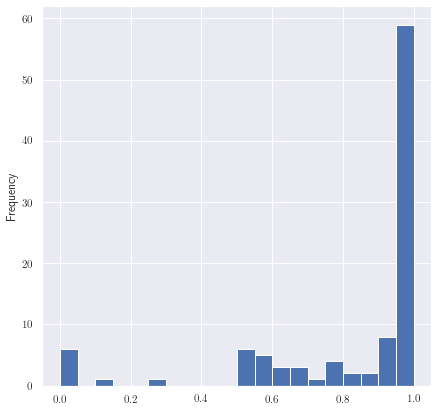

In [94]:
decomp_table.FinalExamFinalScore.plot.hist(bins=20)

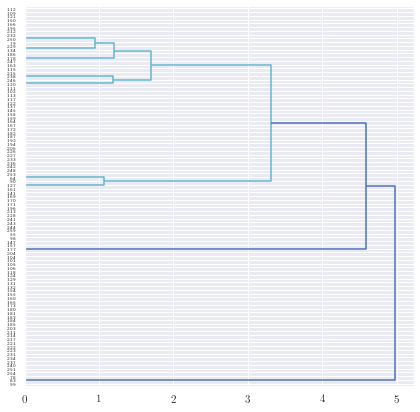

In [64]:
decomp_columns = [name+field for name in decomposition_problems for field in ("Decomposed",)]
decomp_normal = decomp_table.fillna(0)

decomp_normal = pd.DataFrame(normalize(decomp_normal[decomp_columns]), columns=decomp_columns)

#plt.figure(figsize=(12, 15))
#plt.title("Dendrograms")  
Z = shc.linkage(decomp_normal, method='ward')
dend = shc.dendrogram(Z, orientation='right', labels=decomp_table.index)
#plt.show()
#pd.Series(dend['color_list'], index=dend['ivl'])
dc = pd.Series(fcluster(Z, 4, criterion='maxclust'), index=decomp_table.index).rename('DecompositionCategory')
plt.show()

Okay, so I think this is making a bit more sense to me. Basically, we have a few different clusters here that can help us identify students behavior over the course of the semester. But it does kind of seem like I should do something more direct, if I'm just going to collapse them into yes/no categorizations anyway.

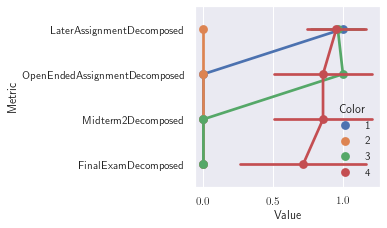

In [65]:
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH))
unstacked = decomp_table[decomp_columns].copy()
unstacked['Color'] = dc
unstacked = unstacked.melt(id_vars='Color', var_name='Metric', value_name='Value')
sns.pointplot(x='Value', y='Metric', hue='Color', data=unstacked, ci='sd')
plt.show()

In [66]:
dc_categories = {1: 'Decomposed Once', 2: 'Never Decomposed', 3: 'Decomposed Early', 4: 'Decomposed Often'}
dc.map(dc_categories).value_counts()
# 1: Started off decomposing but then didn't again.
# 2: Never decomposed.
# 3: Decomposed outside of the exam but not during the exam.
# 4: Mixed decomposition across the semester, but largely positive

Decomposed Once     35
Decomposed Early    27
Decomposed Often    21
Never Decomposed    18
Name: DecompositionCategory, dtype: int64

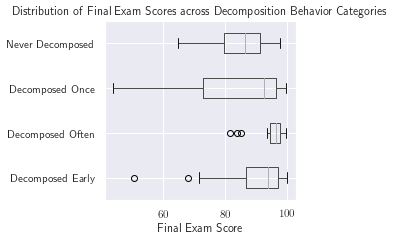

In [67]:
#category_scores = subjects.join(dc).dropna().groupby('DecompositionCategory').FinalExamScore
#display(category_scores.mean())
#category_scores.agg(['mean', 'std', 'min', 'max'])
subjects_with_dc_cats = subjects.join(dc.map(dc_categories)).dropna()
#fig = plt.figure()
subjects_with_dc_cats.boxplot('FinalExamScore', 'DecompositionCategory', vert=False,
                              figsize=(COLUMN_WIDTH, COLUMN_WIDTH))
plt.suptitle("")
plt.xlabel("Final Exam Score")
plt.title("Distribution of Final Exam Scores across Decomposition Behavior Categories")
plt.show()

# Function Subskills

We've chosen a number of subskills that we think are particularly important and interesting regarding functions. We had some expectation that students struggled with these throughout the semester.

In [68]:
from ast_utilities import find_returns, find_calls

In [69]:
# We'll collect data for just the midterms, final, and two projects
all_exam_questions = {
    'midterm1': ['257', '258', '259', '260'],
    'midterm2': ['281', '282', '283', '284', '285'],
    'final': ['289', '290', '291', '292', '293', '294'],
    #'project3': ['254'],
    #'project4': ['273'],
}
flat_exam_questions = [question for questions in all_exam_questions.values() for question in questions]

### Print vs. Return

First we look at the number of students who printed instead of returned.

For each submission, determine if there is a print call but not a return statement. We need to exclude midterm questions #1 and #3 and both projects, since they are supposed to have printed there.

In [70]:
for name, aids in all_exam_questions.items():
    result_students = set()
    for q, aid in enumerate(aids, 1):
        if aid in ('256', '258'): continue
        rvp_logs = logs[logs.AssignmentID==aid]
        rvp_subs = rvp_logs[rvp_logs.EventType=='Intervention']
        rvp_code = rvp_subs.merge(code, left_on='CodeStateID', right_index=True)
        rvp_code['HasReturn'] = rvp_code.Contents.map(find_returns).map(bool)
        rvp_code['HasPrint'] = rvp_code.Contents.map(lambda c: find_calls(c, 'print')).map(bool)
        result_students.update(rvp_code[rvp_code.HasPrint&~rvp_code.HasReturn].SubjectID.unique())
        #print(name, q, rvp_code[rvp_code.HasPrint&~rvp_code.HasReturn].groupby('SubjectID').Score.count().count())
    proportion_stats(len(subjects)-len(result_students), len(subjects), name)

midterm1 n=83, M=80.6%, SD=0.04
midterm2 n=92, M=89.3%, SD=0.03
final n=94, M=91.3%, SD=0.03


### Used Input

In [71]:
# Most students don't use input on the first exam question
for name, aids in all_exam_questions.items():
    result_students = set()
    for q, aid in enumerate(aids, 1):
        if aid in ('256', '258'): continue
        rvp_logs = logs[logs.AssignmentID==aid]
        rvp_subs = rvp_logs[rvp_logs.EventType=='Intervention']
        rvp_code = rvp_subs.merge(code, left_on='CodeStateID', right_index=True)
        rvp_code['HasInput'] = rvp_code.Contents.map(lambda c: find_calls(c, 'input')).map(bool)
        result_students.update(rvp_code[rvp_code.HasInput].SubjectID.unique())
        #print(name, q, rvp_code[rvp_code.HasInput].groupby('SubjectID').Score.count().count())
    proportion_stats(len(subjects)-len(result_students), len(subjects), name)

midterm1 n=99, M=96.1%, SD=0.02
midterm2 n=103, M=100.0%, SD=0.0
final n=102, M=99.0%, SD=0.01


### Unit Tested

In [72]:
# Used any kind of unit testing on the exam
time_periods = []
for name, aids in all_exam_questions.items():
    result_students = set()
    for q, aid in enumerate(aids, 1):
        rvp_logs = logs[logs.AssignmentID==aid]
        rvp_subs = rvp_logs[rvp_logs.EventType=='Intervention']
        rvp_code = rvp_subs.merge(code, left_on='CodeStateID', right_index=True)
        rvp_code['HasAsserts'] = rvp_code.Contents.map(lambda c: find_calls(c, 'assert_equal')).map(bool)
        students_who_asserted = rvp_code[rvp_code.HasAsserts].SubjectID.unique()
        result_students.update(students_who_asserted)
    time_periods.append(pd.Series(subjects.index.isin(result_students), subjects.index).rename(name))
        #print(name, q, rvp_code[rvp_code.HasAsserts].groupby('SubjectID').Score.count().count())
    proportion_stats(len(result_students), len(subjects), name)
testing_growth = pd.concat(time_periods, axis=1)

midterm1 n=91, M=88.3%, SD=0.03
midterm2 n=82, M=79.6%, SD=0.04
final n=69, M=67.0%, SD=0.05


In [73]:
testing_growth.applymap(str).sum(axis=1).value_counts()

TrueTrueTrue       56
TrueTrueFalse      21
TrueFalseFalse      8
TrueFalseTrue       6
FalseTrueTrue       5
FalseFalseFalse     5
FalseFalseTrue      2
dtype: int64

### Syntactically Correct Header

In [74]:
# Count the number of syntax errors caused by faulty headers
def parses(code) -> bool:
    try:
        ast.parse(code)
    except SyntaxError:
        return False
    return True

# Most students don't use input on the first exam question
def any_syntax_errors_with_defs(row):
    code = row.Contents.split("\n")
    line = row.SyntaxErrorLine
    return any(line.strip().startswith('def') for line in code[line-1:line+1])
    #return code[line-1:line+1]

for name, aids in all_exam_questions.items():
    result_students = set()
    for q, aid in enumerate(aids, 1):
        if aid == '256': continue
        rvp_logs = logs[logs.AssignmentID==aid]
        rvp_subs = rvp_logs[(rvp_logs.InterventionType=='Syntax|Syntax error')&(rvp_logs.EventType=='Intervention')]
        rvp_code = rvp_subs.merge(code, left_on='CodeStateID', right_index=True)
        rvp_code['SyntaxErrorLine'] = rvp_code.InterventionMessage.str.extract('line (\d\d?)').astype(int)
        rvp_code['DefLines'] = rvp_code.Contents.str.findall('^(def .*)\w*')
        rvp_code['HeadersFails'] = rvp_code.DefLines.apply(lambda fs: any(not parses(f+' pass') for f in fs) if fs else False)
        rvp_parses = rvp_code[rvp_code['HeadersFails']]
        result_students.update(rvp_parses.SubjectID.unique())
        #print(name, q, rvp_parses.groupby("SubjectID").HeadersFails.count().count())
        #rvp_code.loc[rvp_parses.index].Contents.apply(lambda c: Markdown(f"```python\n{c}\n```")).apply(display)
        #rvp_code.loc[rvp_parses.index].Contents.apply(print)
    proportion_stats(len(subjects)-len(result_students), len(subjects), name)

midterm1 n=86, M=83.5%, SD=0.04
midterm2 n=87, M=84.5%, SD=0.04
final n=94, M=91.3%, SD=0.03


### Had Header Types

In [75]:
# Count the number of syntax errors caused by faulty headers
def parses(code) -> bool:
    try:
        tree = ast.parse(code)
    except SyntaxError:
        return False
    annotations = []
    for i, exp in enumerate(tree.body):
        if isinstance(exp, ast.FunctionDef):
            annotations += [arg.annotation for arg in exp.args.args]
            annotations.append(exp.returns)
    return all(annotations)

for name, aids in all_exam_questions.items():
    result_students = set()
    for q, aid in enumerate(aids, 1):
        if aid == '256': continue
        rvp_logs = logs[logs.AssignmentID==aid]
        rvp_subs = rvp_logs[rvp_logs.EventType=='Intervention']
        rvp_code = rvp_subs.merge(code, left_on='CodeStateID', right_index=True)
        rvp_code['DefLines'] = rvp_code.Contents.str.findall('^(def .*)\w*')
        rvp_code['HeaderTypes'] = rvp_code.DefLines.apply(lambda fs: all(parses(f+' pass') for f in fs)
                                                           if fs else False)
        rvp_headertypes = rvp_code[rvp_code['HeaderTypes']]
        uniques = rvp_headertypes.SubjectID.unique()
        result_students.update(uniques)
        print("\t", name, q, len(uniques))
        #print(name, q, rvp_parses.groupby("SubjectID").HeadersFails.count().count())
        #rvp_code.loc[rvp_parses.index].Contents.apply(lambda c: Markdown(f"```python\n{c}\n```")).apply(display)
        #rvp_code.loc[rvp_parses.index].Contents.apply(print)
    proportion_stats(len(subjects)-len(result_students), len(subjects), name)

	 midterm1 1 30
	 midterm1 2 9
	 midterm1 3 29
	 midterm1 4 47
midterm1 n=42, M=40.8%, SD=0.05
	 midterm2 1 42
	 midterm2 2 20
	 midterm2 3 42
	 midterm2 4 18
	 midterm2 5 20
midterm2 n=47, M=45.6%, SD=0.05
	 final 1 55
	 final 2 51
	 final 3 51
	 final 4 21
	 final 5 22
	 final 6 22
final n=39, M=37.9%, SD=0.05


### Decomposed


In [76]:
for name, aids in all_exam_questions.items():
    result_students = set()
    for q, aid in enumerate(aids, 1):
        if aid in ('256', '258'): continue
        rvp_logs = logs[logs.AssignmentID==aid]
        rvp_subs = rvp_logs[rvp_logs.EventType=='Intervention']
        rvp_code = rvp_subs.merge(code, left_on='CodeStateID', right_index=True)
        rvp_code['DidDecompose'] = rvp_code.Contents.map(decomposed_function)
        result_students.update(rvp_code[rvp_code.DidDecompose].SubjectID.unique())
        #rvp_code[rvp_code.Contents.map(decomposed_function)].Contents.map(print)
        #print(name, q, rvp_code[rvp_code.HasPrint&~rvp_code.HasReturn].groupby('SubjectID').Score.count().count())
    proportion_stats(len(result_students), len(subjects), name)

midterm1 n=1, M=1.0%, SD=0.01
midterm2 n=18, M=17.5%, SD=0.04
final n=20, M=19.4%, SD=0.04


### Parameter Overwrite

In [77]:
for name, aids in all_exam_questions.items():
    #if name != 'final': continue
    result_students = set()
    for q, aid in enumerate(aids, 1):
        #if aid in ('256', '258'): continue
        rvp_logs = logs[logs.AssignmentID==aid]
        rvp_subs = rvp_logs[rvp_logs.EventType=='Intervention']
        rvp_code = rvp_subs.merge(code, left_on='CodeStateID', right_index=True)
        rvp_code['OverwroteParameters'] = rvp_code.Contents.map(function_with_reinitialization).map(bool)
        result_students.update(rvp_code[rvp_code.OverwroteParameters].SubjectID.unique())
        #rvp_code[rvp_code['OverwroteParameters']].Contents.map(print)
        #print(name, q, rvp_code[rvp_code.HasPrint&~rvp_code.HasReturn].groupby('SubjectID').Score.count().count())
    proportion_stats(len(subjects)-len(result_students), len(subjects), name)

midterm1 n=91, M=88.3%, SD=0.03
midterm2 n=101, M=98.1%, SD=0.01
final n=102, M=99.0%, SD=0.01


# Prediction

Do any assignments in the course predict final exam score?

A smattering have some amount of correlation. Nothing too overwhelming.

#14.3) Type Errors 0.48885522270519727


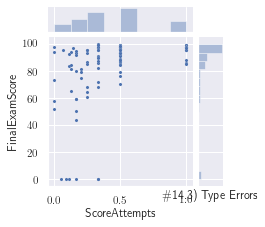

#16.7) User and Dogs 0.4337029225866546


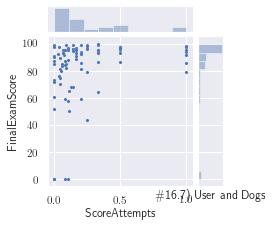

#17.2) Functions Calls and Variables 0.4636186911190354


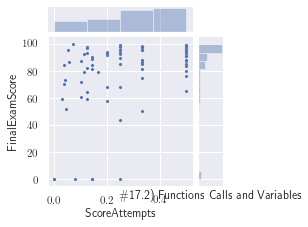

#18.2) Highs and Lows 0.424929386982672


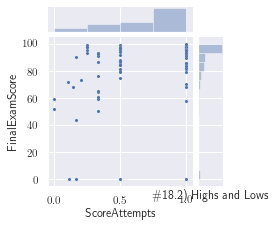

#18.4) Parameters vs. Arguments 0.4606582742196686


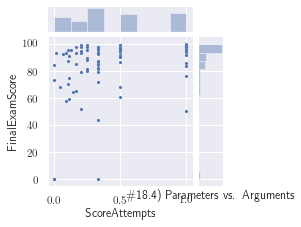

#20.2) A Do Nothing Function 0.414427644524276


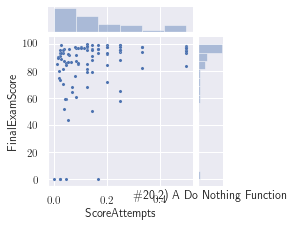

#21.1) Mysterious Math 0.4242689638092103


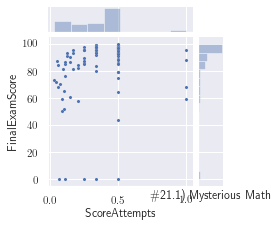

#21.2) Mysterious Strings 0.4401777932287862


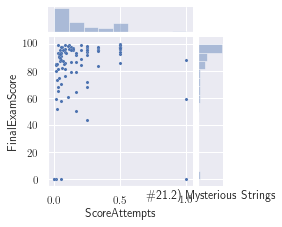

#21.3) Be Polite 0.41208115757554603


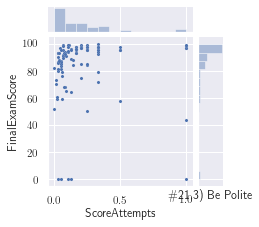

#25.1) Timely Extraction 0.4667513402425435


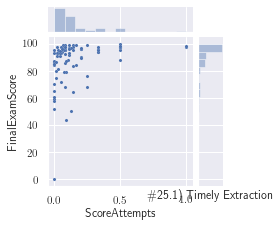

#27.1) Rainy Days 0.4214481717310386


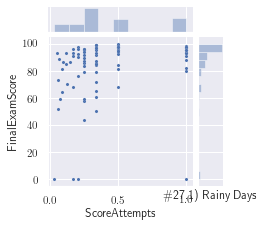

#29.1) Drinking Function 0.5818978089504646


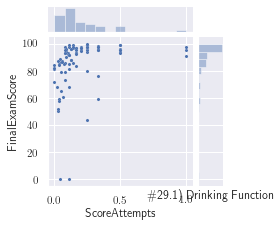

#29.4) Stay Positive 0.40335774143214687


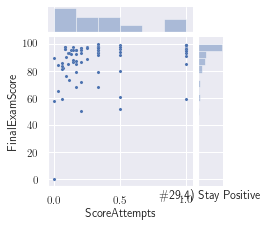

Part 2 - Question 2 0.4101255792007212


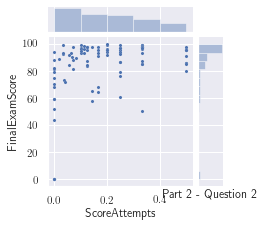

Part 2 - Question 3 0.6333800769063382


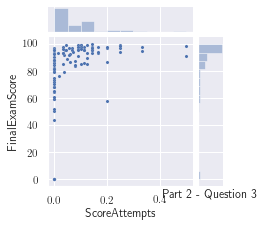

Part 2 - Question 4 0.5995865228420998


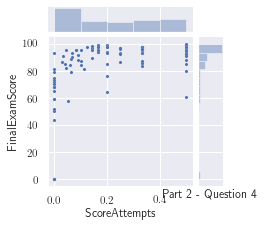

Part 2 - Question 5 0.5439133358495549


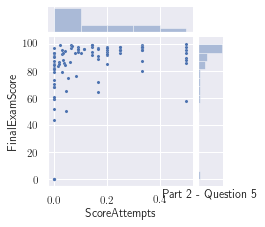

Project 3- Magical Banking 0.5184470277972864


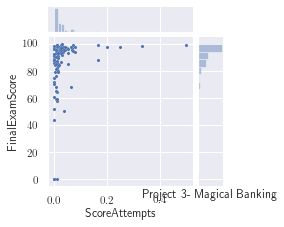

#22.1) Print greeting 0.4438421564252477


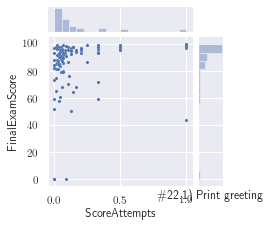

#22.2) Return greetting 0.43324320493742396


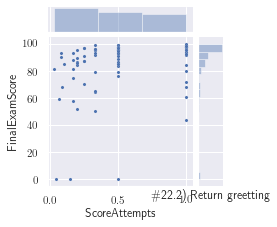

#22.5) Making a Receipt 0.4434196972772278


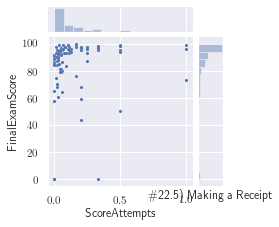

#23.1) Outside the Perimeter 0.41005312617390616


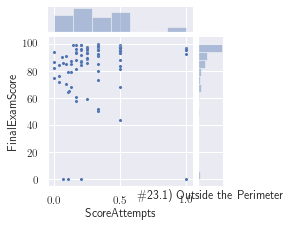

#31.3) Last 0.40693116316997774


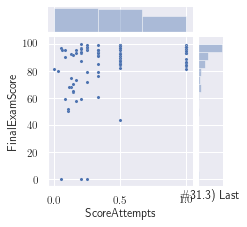

#32.1) Hello Names 0.5552955702275814


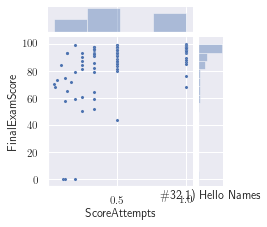

#32.4) Function with For 0.44696992593990015


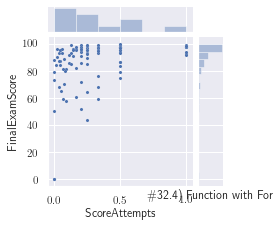

#32.5) For with Function 0.4912818151501427


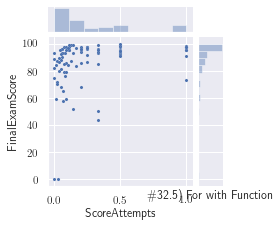

#35.2) Compose Some Functions 0.4300053109497224


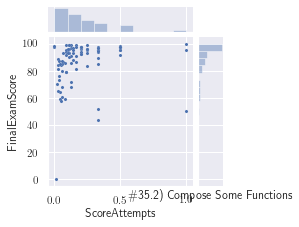

#37.1) Sum String 0.4534463494903906


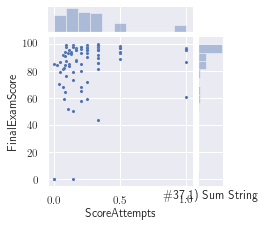

#39.2) Name Check 0.5063725865295596


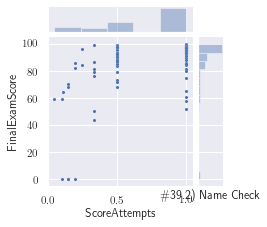

#39.3) Name Function 0.4886196997825541


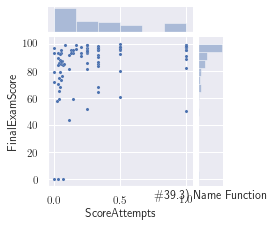

#43.3) Summing LoD 0.5399193724396328


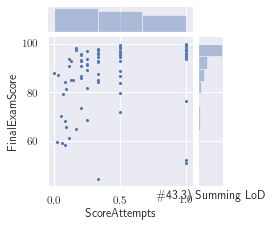

M2- P2- Q2 0.5622173175824404


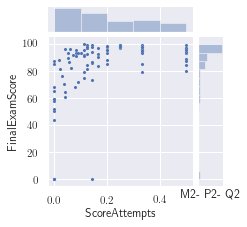

M2- P2- Q3 0.4961475523386293


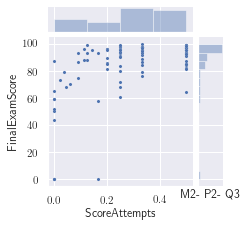

M2- P2- Q4 0.5698723571648199


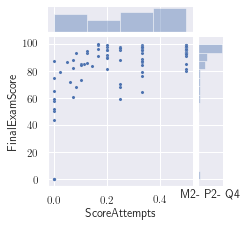

M2- P2- Q5 0.6359424618190824


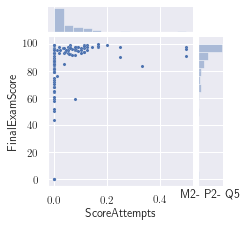

FE Part 2) Question 4 0.6940304816295931


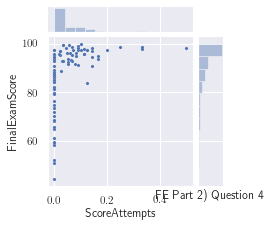

FE Part 2) Question 5 0.554345907209049


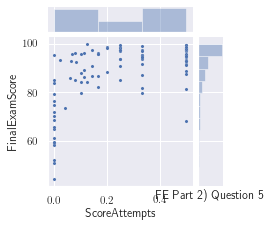

FE Part 2) Question 6 0.678051588602194


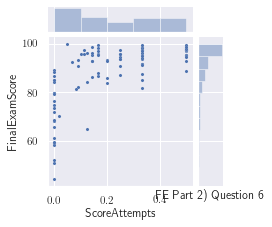

In [78]:
assignment_correlations = []
for aid, assignment in assignments.iterrows():
    submission_groups = submissions[submissions.AssignmentID==aid].groupby("SubjectID")
    scores = submission_groups.Score.max().replace({'': 0}).astype(float).fillna(0)
    attempts = submission_groups.Score.count()
    score_attempts = subjects.join(((scores/attempts)).rename('ScoreAttempts'))
    combined = score_attempts[['ScoreAttempts', 'FinalExamScore']].dropna()
    corr, pvalue = st.spearmanr(combined.ScoreAttempts, combined.FinalExamScore)
    if pvalue < .05 and corr > .4:
        assignment_correlations.append([assignment.AssignmentName, corr])
        print(assignment.AssignmentName, corr)
        sns.jointplot(x=combined.ScoreAttempts, y=combined.FinalExamScore, kind='scatter', height=COLUMN_WIDTH,
                 s=10, edgecolor="w", linewidth=.1)
        plt.xlabel(tex_escape(assignment.AssignmentName))
        plt.show()
#pd.DataFrame(assignment_correlations, columns=['Assignment', 'Correlation']).set_index('Assignment').sort_values('Correlation').tail(30)

# Error Classification

Let's break down all the different kinds of errors

In [79]:
logs.EventType.value_counts()

File.Edit                   909506
Compile                     125408
Intervention                122511
Run.Program                  95702
Session.Start                56293
X-Submission.LMS             28155
Compile.Error                25872
File.Create                  17609
X-View.Change                 6659
X-File.Reset                  4379
X-IP.Change                   4309
X-File.Add                    3556
X-Evaluate.Program            2463
X-Instructions.Change         1999
Submit                         514
X-File.Upload                  456
X-Image.Save                   331
X-File.Download                232
X-Submission.LMS.Failure       140
Name: EventType, dtype: int64

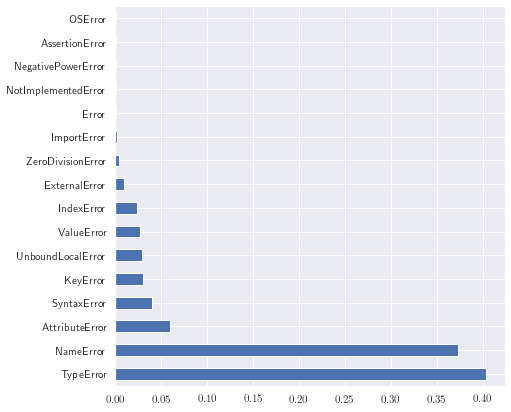

In [80]:
#submissions[submissions.InterventionType.str.startswith('Runtime')].InterventionType.value_counts().head(40)
#logs.EventType.value_counts()
error_types =logs[logs.EventType=='Compile.Error'].CompileMessageData.str.extract("(.*?Error):").squeeze().value_counts()
(error_types / error_types.sum()).plot.barh()
plt.show()

In [81]:
# Okay, that's clearly not all the data. Can't trust Compile.Error, that's too bad.
logs[(logs.EventType=='Compile.Error')&(logs.CompileMessageData.str.startswith("SyntaxError"))]

,SubjectID,AssignmentID,EventType,CodeStateID,ClientTimestamp,ServerTimestamp,Score,EditType,DueDelta,DueHours,DueSeconds,SemesterDelta,SemesterHours,DurationDelta,DurationSeconds,CompileMessageType,CompileMessageData,InterventionCategory,InterventionType,InterventionMessage
EventID,,,,,,,,,,,,,,,,,,,,
1619005,101,257,Compile.Error,374793,2019-10-02 15:36:21.887,2019-10-02 14:22:31.445012,,,2 days 08:23:37.113000,56.39,203017.11,71 days 01:14:26.577871,1705.24,00:00:00.003086,0.00,Error,SyntaxError: bad input on line 1,,,
1707978,101,126,Compile.Error,409230,2019-10-04 09:12:48.338,2019-10-04 08:12:49.627215,,,10 days 14:47:10.662000,254.79,917230.66,69 days 07:38:00.126871,1663.63,00:00:00.000818,0.00,Error,SyntaxError: 'return' outside function,,,
1740156,101,118,Compile.Error,422606,2019-10-07 10:32:48.987,2019-10-07 09:32:49.815690,,,7 days 13:27:10.013000,181.45,653230.01,66 days 06:17:59.477871,1590.30,00:00:00.000838,0.00,Error,SyntaxError: 'return' outside function,,,
2302981,101,273,Compile.Error,686023,2019-10-21 20:57:08.269,2019-10-21 19:57:09.101385,,,3 days 03:01:51.731000,75.03,270111.73,51 days 19:53:40.195871,1243.89,00:00:00.000006,0.00,Error,SyntaxError: bad input on line 1,,,
2468701,101,168,Compile.Error,768000,2019-10-28 10:36:18.794,2019-10-28 09:36:19.713320,,,4 days 13:23:40.206000,109.39,393820.21,45 days 06:14:29.670871,1086.24,00:00:00.000848,0.00,Error,SyntaxError: 'return' outside function,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973032,99,71,Compile.Error,126308,2019-09-17 19:01:51.315,2019-09-17 18:01:52.429362,,,8 days 04:58:07.685000,196.97,709087.69,85 days 21:48:57.149871,2061.82,00:00:00.003678,0.00,Error,SyntaxError: duplicate argument 'int' in funct...,,,
2410839,99,161,Compile.Error,738804,2019-10-24 14:31:08.511,2019-10-24 13:31:11.679126,,,6 days 09:28:50.489000,153.48,552530.49,49 days 02:19:39.953871,1178.33,00:00:00.007373,0.01,Error,SyntaxError: 'return' outside function,,,
2410913,99,161,Compile.Error,738852,2019-10-24 14:32:02.873,2019-10-24 13:32:05.772499,,,6 days 09:27:56.127000,153.47,552476.13,49 days 02:18:45.591871,1178.31,00:00:01.532392,1.53,Error,SyntaxError: 'return' outside function,,,


In [82]:
programming_assignments = assignments[assignments.AssignmentName.str.startswith("#")].index
non_exam_submissions = submissions[submissions.AssignmentID.isin(programming_assignments)]
intervention_type_counts = non_exam_submissions.InterventionType.str.extract("(.*?)\|").squeeze().value_counts()
(100*intervention_type_counts/intervention_type_counts.sum())

instructor     37.83
Analyzer       22.07
Complete       17.76
Syntax         11.37
Runtime         7.83
instructions    2.35
no errors       0.79
Name: 0, dtype: float64

In [83]:
(100*non_exam_submissions.InterventionType.value_counts() / non_exam_submissions.InterventionType.value_counts().sum()).head(30)

instructor|Instructor Feedback             32.05
Complete|Complete                          17.76
Syntax|Syntax error                        11.08
Analyzer|Initialization Problem             6.93
Analyzer|Unused Variable                    5.89
Runtime|TypeError                           3.71
instructor|Student Unit Tests Failing       2.92
Analyzer|Multiple Return Types              2.91
instructions|Guidance                       1.98
Analyzer|Incompatible types                 1.41
Runtime|NameError                           1.02
Analyzer|Parameter Type Mismatch            1.02
instructor|Not Enough Student Unit Tests    1.01
Runtime|AttributeError                      0.80
no errors|No errors                         0.79
instructor|Missing Print                    0.76
Analyzer|Overwritten Variable               0.58
Runtime|object                              0.57
Analyzer|Read out of scope                  0.51
Analyzer|tifa_error                         0.51
Analyzer|Iterating o

In [84]:
generic_instructor_feedback = submissions[submissions.InterventionType == 'instructor|Instructor Feedback'].InterventionMessage.value_counts()
generic_instructor_feedback.sum()
# Failing instructor tests: (2531+895)/37207
# Failing unit tests: 1362/37207
# Inadequate coverage: 895/37207
(2531+895)/len(submissions)

0.0279648358106619

In [85]:
non_exam_submissions[non_exam_submissions.InterventionType =="instructor|Instructor Feedback"].InterventionMessage.sample(10).map(print)

<p>Error in definition of function <code>bookend_list</code> parameter <code>list</code>. Expected <code>list</code>, instead found <code>str</code>.<br><br><i>(wrong_parameter_type)<i></br></br></p>

<p>I ran your function <code>get_front_of_weekdays</code> on some new arguments, and it failed 2/5 tests.<table class='blockpy-feedback-unit table table-condensed table-bordered table-hover'><tr class='active'><th></th><th>Arguments</th><th>Returned</th><th>Expected</th></tr><tr class=''><td class='green-check-mark'>&#10004;</td><td><code><code>'monday'</code></code></td><td><code>'mon'</code></td><td><code>'mon'</code></td></tr><tr class=''><td class='green-check-mark'>&#10004;</td><td><code><code>'friday'</code></code></td><td><code>'fri'</code></td><td><code>'fri'</code></td></tr><tr class=''><td class='green-check-mark'>&#10004;</td><td><code><code>'thursday'</code></code></td><td><code>'thurs'</code></td><td><code>'thurs'</code></td></tr><tr class=''><td>&#10060;</td><td><code><code>

EventID
1825115    None
2148514    None
1030709    None
903863     None
740493     None
1790659    None
1265054    None
2083302    None
1216216    None
2350242    None
Name: InterventionMessage, dtype: object

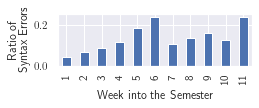

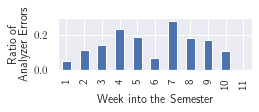

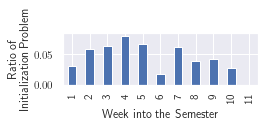

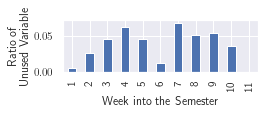

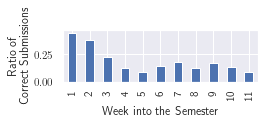

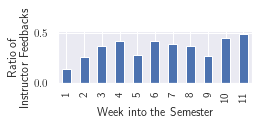

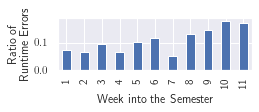

In [86]:
for category, label, filename in [('Syntax', 'Syntax Errors', 'syntax'),
                                  ('Analyzer', 'Analyzer Errors', 'analyzer'),
                                  ('Analyzer|Initialization Problem', 'Initialization Problem', 'initproblem'),
                                  ('Analyzer|Unused Variable', 'Unused Variable', 'unusedvar'),
                                  ('Complete', 'Correct Submissions', 'complete'),
                                  ('instructor', 'Instructor Feedbacks', 'instructor'),
                                  ('Runtime', 'Runtime Errors', 'runtime')]:
    syntax_errors = submissions[submissions.InterventionType.str.startswith(category)]
    # Have to trim out some bad data from weeks 12-15
    scdw = syntax_errors.ClientTimestamp.dt.week
    syntax_errors = syntax_errors[(scdw<11+FIRST_WEEK)|((14+FIRST_WEEK)<scdw)]
    semester_weeks = syntax_errors.assign(SemesterWeek=syntax_errors.ClientTimestamp.dt.week)
    totals = submissions.assign(SemesterWeek=submissions.ClientTimestamp.dt.week).groupby('SemesterWeek').SubjectID.count()
    weekly_syntax_errors = semester_weeks.groupby('SemesterWeek').SubjectID.count()/totals
    weekly_syntax_errors.index = (weekly_syntax_errors.index - FIRST_WEEK+1)
    weekly_syntax_errors = weekly_syntax_errors.reindex(range(1, 12), fill_value=0)
    plt.figure(figsize=(TEXT_WIDTH/2, COLUMN_WIDTH/3.5))
    plt.ylabel(f"Ratio of\n{label}")
    #plt.title(f"Ratio of {label} in Events\nby Week of Semester")
    weekly_syntax_errors.plot.bar()
    plt.xlabel("Week into the Semester")
    save_figure(f'bar_ratio_{filename}_errors.pdf')
    plt.show()